In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split

# Regression Network

In [3]:
class LocalizationCNN(nn.Module):
    def __init__(self):
        # super(LocalizationCNN, self).__init__()
        # self.features = nn.Sequential(
        #     nn.Conv2d(15, 32, kernel_size=5, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2),
        #     nn.BatchNorm2d(32),

        #     nn.Conv2d(32, 64, kernel_size=10, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2),
        #     nn.BatchNorm2d(64),

        #     nn.Conv2d(64, 128, kernel_size=5, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2),
        #     nn.BatchNorm2d(128)
        # )
        
        # self.regressor = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(128 * 1 * 1, 256),  # Adjust the size based on the output of the last conv layer
        #     nn.ReLU(),
        #     nn.Dropout(0.5),
        #     nn.Linear(256, 6)  # Output layer for x, y coordinates and velocities
        # )
        
        super(LocalizationCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(15, 32, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size=10, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),
        )
        
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 12 * 12, 128),  # Adjust the size based on the output of the last conv layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 6)  # Output layer for x, y coordinates and velocities
        )
        

    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x

# Load and prepare the dataset
def load_data(X, Y, training_size=0.8):
    dataset = TensorDataset(X, Y)

    # Splitting dataset into training and validation
    train_size = int(training_size * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    return train_dataset, val_dataset

def train_model(model, device, train_loader, val_loader, optimizer, loss_function, epochs):
    model.train()
    training_losses = []
    validate_losses = []
    for epoch in range(epochs):
        total_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.size(0)
        training_avg_loss = total_loss / len(train_loader.dataset)
        training_losses.append(training_avg_loss) # average loss for each epoch
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_function(output, target)
            total_loss += loss.item() * data.size(0)
        validate_avg_loss = total_loss / len(val_loader.dataset)
        validate_losses.append(validate_avg_loss)
        print(f'Epoch {epoch+1}, Training Loss: {training_avg_loss:.7f}, Validation Loss: {validate_avg_loss:.7f}')
    return training_losses, validate_losses

def validate_model(model, device, val_loader, loss_function):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_function(output, target)
            total_loss += loss.item() * data.size(0)
    avg_loss = total_loss / len(val_loader.dataset)
    print(f'Validation Loss: {avg_loss:.4f}')
    return avg_loss

def plot_learning_curves(training_losses, validation_losses, start, title):
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses[start:], label='Training Loss')
    plt.plot(validation_losses[start:], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Training

In [4]:
# load training data
X = torch.load('training_images.pt')
Y = torch.load('position_labels.pt')
# Y = torch.load('velocity_labels.pt')
print(X.shape, Y.shape)

torch.Size([2000, 15, 64, 64]) torch.Size([2000, 6])


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
# Load data
train_dataset, val_dataset = load_data(X, Y)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # data set sorted into batches of 64 and shuffled
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [6]:
# Initialize the model and other components
model = LocalizationCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss()

# Training and Validation
training_losses, validate_losses = train_model(model, device, train_loader, val_loader, optimizer, loss_function, epochs=500)

Epoch 1, Training Loss: 1.0853563, Validation Loss: 4.7325129
Epoch 2, Training Loss: 0.3366703, Validation Loss: 1.6386223
Epoch 3, Training Loss: 0.2731790, Validation Loss: 1.3632940
Epoch 4, Training Loss: 0.2649366, Validation Loss: 1.2920478
Epoch 5, Training Loss: 0.2483679, Validation Loss: 1.2207439
Epoch 6, Training Loss: 0.2378865, Validation Loss: 1.1735407
Epoch 7, Training Loss: 0.2208737, Validation Loss: 1.0876469
Epoch 8, Training Loss: 0.2085695, Validation Loss: 1.0214241
Epoch 9, Training Loss: 0.2048084, Validation Loss: 1.0291280
Epoch 10, Training Loss: 0.1835917, Validation Loss: 0.9142716
Epoch 11, Training Loss: 0.1954426, Validation Loss: 0.9722687
Epoch 12, Training Loss: 0.1931523, Validation Loss: 0.9489886
Epoch 13, Training Loss: 0.1874294, Validation Loss: 0.9348192
Epoch 14, Training Loss: 0.1766665, Validation Loss: 0.8598632
Epoch 15, Training Loss: 0.1622716, Validation Loss: 0.8049132
Epoch 16, Training Loss: 0.1978129, Validation Loss: 0.9553876
E

KeyboardInterrupt: 

In [13]:
np.round(Y[:100], 3)

tensor([[ 0.0150, -0.0050,  0.0000,  0.0300, -0.0110,  0.0000],
        [ 0.0130, -0.0090,  0.0000,  0.0260, -0.0180,  0.0000],
        [ 0.0110, -0.0120,  0.0000,  0.0210, -0.0240,  0.0000],
        [ 0.0070, -0.0140,  0.0000,  0.0140, -0.0280,  0.0000],
        [ 0.0030, -0.0160,  0.0000,  0.0070, -0.0310,  0.0000],
        [-0.0000, -0.0160,  0.0000, -0.0010, -0.0320,  0.0000],
        [-0.0040, -0.0150,  0.0000, -0.0090, -0.0310,  0.0000],
        [-0.0080, -0.0140,  0.0000, -0.0160, -0.0280,  0.0000],
        [-0.0110, -0.0110,  0.0000, -0.0220, -0.0230,  0.0000],
        [-0.0140, -0.0080,  0.0000, -0.0270, -0.0160,  0.0000],
        [-0.0150, -0.0050,  0.0000, -0.0310, -0.0090,  0.0000],
        [-0.0160, -0.0010,  0.0000, -0.0320, -0.0010,  0.0000],
        [-0.0160,  0.0030,  0.0000, -0.0310,  0.0070,  0.0000],
        [-0.0140,  0.0070,  0.0000, -0.0290,  0.0140,  0.0000],
        [-0.0120,  0.0100,  0.0000, -0.0240,  0.0210,  0.0000],
        [-0.0090,  0.0130,  0.0000, -0.0

In [25]:
np.round(model(X[:100]), 3)

tensor([[ 0.0120, -0.0050, -0.0000,  0.0250, -0.0120,  0.0000],
        [ 0.0050, -0.0040, -0.0000,  0.0110, -0.0090,  0.0000],
        [ 0.0110, -0.0140, -0.0000,  0.0240, -0.0300, -0.0000],
        [ 0.0050, -0.0130, -0.0000,  0.0110, -0.0280,  0.0000],
        [-0.0030, -0.0170,  0.0000,  0.0010, -0.0350,  0.0020],
        [-0.0040, -0.0150, -0.0000, -0.0070, -0.0320,  0.0000],
        [-0.0100, -0.0110, -0.0000, -0.0180, -0.0240,  0.0000],
        [-0.0140, -0.0120,  0.0000, -0.0270, -0.0280, -0.0000],
        [-0.0150, -0.0100,  0.0000, -0.0290, -0.0240,  0.0000],
        [-0.0140, -0.0070,  0.0000, -0.0260, -0.0170,  0.0000],
        [-0.0180, -0.0020,  0.0000, -0.0340, -0.0090,  0.0000],
        [-0.0140,  0.0050, -0.0000, -0.0260,  0.0070,  0.0000],
        [-0.0170,  0.0070, -0.0000, -0.0290,  0.0110,  0.0000],
        [-0.0140,  0.0090,  0.0010, -0.0270,  0.0140,  0.0000],
        [-0.0170,  0.0170, -0.0000, -0.0300,  0.0300, -0.0000],
        [-0.0080,  0.0120, -0.0000, -0.0

In [6]:
# Save the trained model
torch.save(model.state_dict(), 'localization_cnn.pt')

In [28]:
# Save the trained model
torch.save(model.state_dict(), 'velocity_cnn.pt')

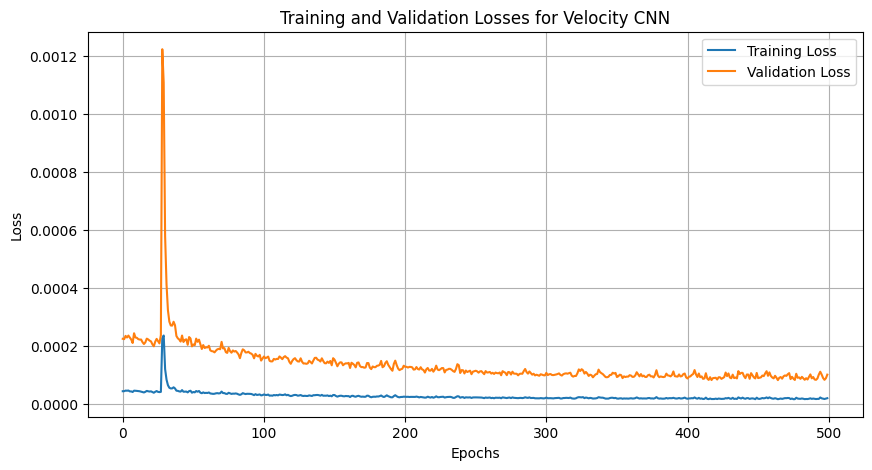

In [27]:
# Plot the learning curves
plot_learning_curves(training_losses, validate_losses, 100, 'Training and Validation Losses for Velocity CNN')

In [ ]:
# Plot the learning curves
plot_learning_curves(training_losses, validate_losses, 0, 'Training and Validation Losses for Velocity CNN')